# ESTIMACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO EN EL TIEMPO

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La probabilidad de incumplimiento se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más.

## 1. Objetivo:

Análisis de las Probabilidades de Incumplimiento de créditos hipotecarios de Estados Unidos para identificar periodos de crisis mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

## 2. Datos:

Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

## 3. Desarrollo:

### Importación de la librería

In [15]:
import IPython
import math
import matplotlib.pyplot as plt
import joblib
import numpy as np
import numpy.matlib
import pandas as pd
import pickle
import pydot
import pylab
import random
import scipy 
import scipy.cluster.hierarchy as shc
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import tabulate
import boto3
import io
from io import StringIO

from numpy import linalg
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.integrate import *
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform 
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, r2_score, make_scorer, mean_squared_error, mean_absolute_error,roc_curve,accuracy_score,roc_auc_score,brier_score_loss, precision_score, recall_score,f1_score, log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen


Esta función se utiliza para determinar el número de dígitos de precisión que se imprimen

In [16]:
np.set_printoptions(precision=3, suppress=True)

### Conexión a la instancia S3

Definición de los parámetros para la conexión a S3

In [17]:
s3client = boto3.client(
    's3',
    region_name='us-east-1'
)

Asignación del nombre del bucket de S3 y de los datos

In [18]:
bucketname = "bucket-mno-2020-v3"
file_to_read = "data_t_final.csv"

Definición objeto de S3 para conectarnos

In [19]:
fileobj = s3client.get_object(
    Bucket=bucketname,
    Key=file_to_read
    )

### Lectura del archivo, decodificación  y conversión a dataframe

Lectura del archivo

In [20]:
filedata = fileobj['Body'].read()

Decodificación del archivo

In [21]:
contenido = filedata.decode('utf-8')

Tipo de archivo

In [22]:
type(contenido)

str

Conversión del archivo a dataframe

In [23]:
StringData = StringIO(contenido)

Lectura del archivo

In [24]:
df = pd.read_csv(StringData)

Visualización del archivo

In [25]:
df

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
1,4,26,-2,25,119,NaN,60882.42,34.007232,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
2,4,27,-2,25,119,NaN,60729.80,34.335349,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
3,4,28,-2,25,119,NaN,60576.14,34.672545,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
4,4,29,-2,25,119,NaN,60424.39,34.951639,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62173,49972,52,25,52,145,NaN,180673.24,103.306966,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62174,49972,53,25,52,145,NaN,179944.95,95.736862,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62175,49972,54,25,52,145,NaN,179451.81,91.867079,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62176,49972,55,25,52,145,NaN,178952.48,91.560581,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN


### Limpieza de la base de datos

Quitamos renglones con datos 

In [27]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

### Data Engineering (falta la selección de las mejores variables, lo tenemos pendiente)

Impresión del nombre de las columnas

In [28]:
for col in data.columns: 
    print(col) 

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


### Modelo

La variable dependiente del modelo de regresión logística es "default-time" que da información relacionada con el incumplimiento de pago en cada período de tiempo. Es una variable binomial con valores 0 o 1.

Se presenta un modelo que incluye todas las variables, una vez realizada la ingeniería de datos se realizará con las variables que más aportación tengan sobre la varianza total de la variable dependiente. Asimismo, fata decidir respecto a si se evaluará el modelo contra un conjunto de prueba.

La regresión se realiza utilizando una función para modelo lineales generalizados, que admiten varios tipos de familias. Para este ejercicio se tomó un binomial.

In [29]:

model_lr = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_PU_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time', family = sm.families.Binomial(), data = data).fit()

Con relación a los p_values podemos observar que la mayoría de la variables son significativas. Entre las variables más significativas que tienen un impacto positivo sobre el incumplimiento de pago tenemos:
* balance_time.- saldo en el periodo de observación
* interest_rate_time.- tasa de interés en el periodo de observación
* LTV_orig_time.- Loan to Value en el momento de la originación
* hpi_orig_time.- índice de precios de casa en el momento de la originación

Las variables más significativas pero que afetan de manera negativamente el incumplimiento de pago son:

* hpi_time.- índice de precios de casas en el periodo de observación
* gdp_time.- tasa de crecimiento del PIB en el periodo de observación
* FICO_orig_time.- FICO score en el momento de originar

Las únicas dos variables que podríamos considerar no significativas son "REtype_CO_orig_time" y "REtype_SF_orig_time. Estas varaibles son identificadoras del tipo de vivienda.

In [30]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62136
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6645.7
Date:                Sat, 05 Dec 2020   Deviance:                       13291.
Time:                        16:16:46   Pearson chi2:                 5.75e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Aplicación del modelo a la base de datos donde asignamos a cada observación la probabilidad de incumplimiento

In [31]:
PD_logit_model = pd.DataFrame(model_lr.fittedvalues, columns=['PD_logit_model'])

In [32]:
PD_logit_model

,PD_logit_model
0,0.007609
1,0.008268
2,0.008482
3,0.010363
4,0.010251
...,...
62173,0.031071
62174,0.027902
62175,0.024614
62176,0.022627


Realización de la tabla por cada perido de tiempo con la variable indicadora de "default" versus "no-default" con su respectiva probabilidad

In [33]:
data2 = pd.merge(df[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

In [34]:
data2

,default_time,time,PD_logit_model
0,0,25,0.007609
1,0,26,0.008268
2,0,27,0.008482
3,0,28,0.010363
4,0,29,0.010251
...,...,...,...
62173,0,52,0.031071
62174,0,53,0.027902
62175,0,54,0.024614
62176,0,55,0.022627


In [35]:

def validation(fit, outcome , time, continuous=False):
    """
    Inputs:
    Valores del modelo  PD_logit_model
    Valores teóricos    default_time
    Tiempo              tiempo
    
    Outputs:
    Media de las probabilidades teóricas
    Media de las probabilidades del modelo
    Métricas de validación del modelo
    Gŕaficas
         
    """
    # Se marca un estilo para la impresión de gráficas
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.rcParams.update({'font.size': 16})
    # Se crean dataframes para los valores arrojados por el modelo, los teóricos y el tiempo
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    if isinstance(fit, pd.Series):
        fit=fit.values
    if isinstance(outcome, pd.Series):
        outcome=outcome.values
    if isinstance(time, pd.Series):
        time=time.values
    # Se obtienen las medias de las probabilidades empíricas y del modelo
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    means = data_in.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
  
    data_in['outcomeD']=data_in.loc[:,'outcome']    
    if continuous==True:
        data_in.loc[data_in['outcome'] >= data_in.outcome.mean(), 'outcomeD'] = 1
        data_in.loc[data_in['outcome'] <  data_in.outcome.mean(), 'outcomeD'] = 0
    
    outcomeD=data_in.loc[:,'outcomeD'].values
    # Se crean métricas para la valoración del modelo. Su análisis se examina junto con los resultados
    lr_log_loss = np.nan
    roc_auc = np.nan
    brier = np.nan
    binom_p = np.nan
    Jeffreys_p =  np.nan
    
    max_outcome_fit=np.maximum(max(outcome), max(fit))
    min_outcome_fit=np.minimum(min(outcome), min(fit)) 
    if min_outcome_fit>=0 and max_outcome_fit<=1:
        lr_log_loss = log_loss(outcomeD, fit).round(4)
        roc_auc = roc_auc_score(outcomeD, fit).round(4)
        binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p= np.mean(fit), alternative='greater').round(decimals=4)
        Jeffreys_p =  beta.cdf(np.mean(fit), sum(outcomeD)+0.5, len(outcomeD)-sum(outcomeD)+0.5).round(decimals=4)

            
    corr,_=pearsonr(fit,outcome)
    r2_OLS=corr**2
    
    the_table = [['Counts', len(outcome)],
                      ['Mean outcome', (sum(outcome)/len(outcome)).round(4)],
                      ['Mean fit', np.mean(fit).round(4)],
                      ['AUC ', roc_auc],
                      ['R-squared (OLS)', round(r2_OLS,4)],
                      ['R-squared', r2_score(outcome, fit).round(decimals=4)],
                      ['RMSE/ SQR(Brier score)', round(np.sqrt(((outcome-fit).dot(outcome-fit))/len(outcome)),4)],
                      ['Log loss', lr_log_loss], 
                      ['Binomial p-value', binom_p],
                      ['Jeffreys p-value', Jeffreys_p]]
    the_table=pd.DataFrame(data=the_table)
    the_table.columns = ['Metric', 'Value']
    # Se realizan gráficas
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
 
    plt.subplot(221)
    plt.title('Summary')
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center', colWidths=[0.34, 0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(16) 
    test.scale(2, 1.5)
    
    plt.subplot(222)
    plt.title('Time-Series Real-Fit')
    plt.plot(means['time'],means['outcome'])
    plt.plot(means['time'],means['fit'], color='red', ls='dashed')
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Mean', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(('Outcome','Fit'), loc='best', fontsize=15)
    
    plt.subplot(223)
    plt.title('Fit Histogram')
    plt.hist(fit, bins=20, histtype='bar', density=True)
    plt.xlabel('Fit', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    
    data_in['cat'] = pd.qcut(data_in.fit, 10, labels=False, duplicates='drop')
    real_fit = data_in.groupby('cat')[['fit', 'outcome']].mean()
    mpv=real_fit.fit.values
    fop=real_fit.outcome.values
    
    maximum=np.maximum(max(fop), max(mpv))       
    maximum=np.ceil(maximum*100)/100
    minimum=np.minimum(min(fop), min(mpv))
    minimum=np.floor(minimum*100)/100
    
    plt.subplot(224)
    plt.title('Calibration Curve')
    plt.plot(mpv, fop, marker='.', linestyle='', markersize=18)
    plt.plot([minimum,maximum],[minimum,maximum], linestyle='--', color='gray')
    plt.xlim((minimum,maximum))
    plt.ylim((minimum,maximum))
    plt.xlabel('Mean fit', fontsize=15)
    plt.ylabel('Mean outcome', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.show()    
  

Se corre la función

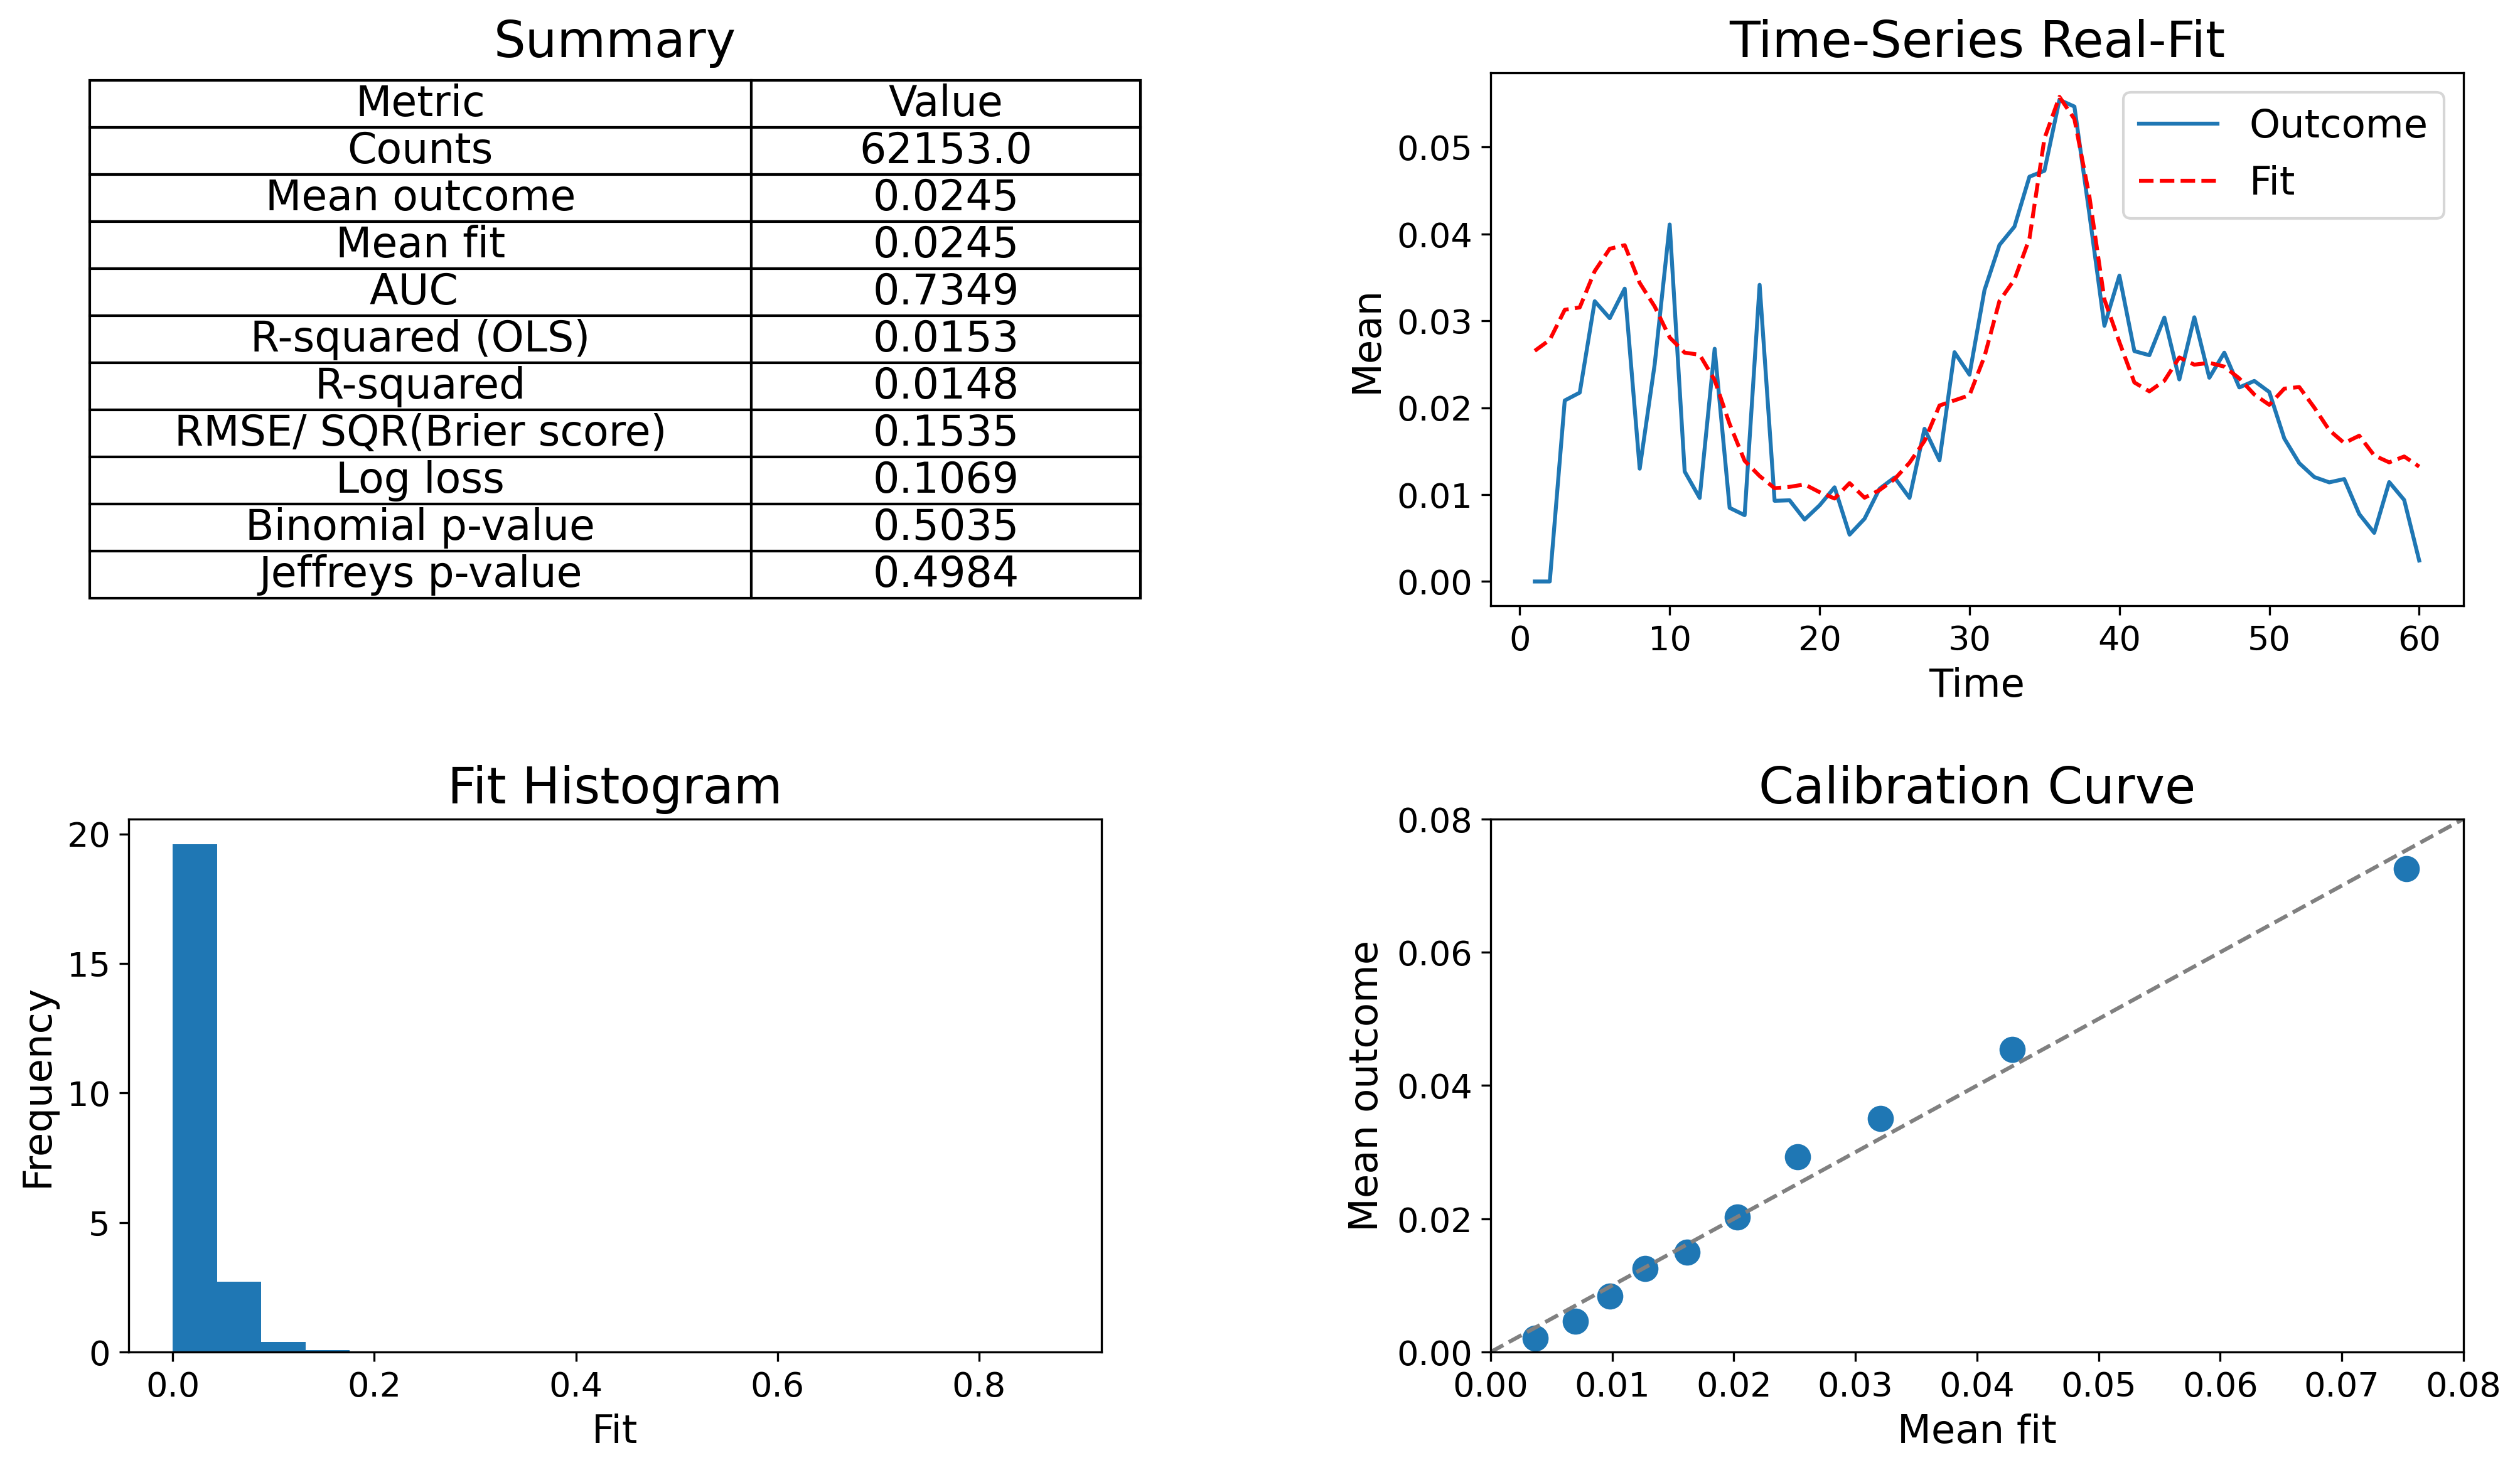

In [36]:

validation(data2.PD_logit_model, data2.default_time, data2.time)

### Hallazgos Importantes

En nuestro primer acercamiento encontramos resultados muy satisfactorios, lo que podemos apreciar bajo distintas métricas. Las medias de las probabilidades empíricas y del modelo son exactamente las mismas .0245. En la gráfica inferior derecha podemos apreciar la correspondencia entre los valores de las medias empíricas y las del modelo sobre la línea de 45°.

Del mismo modo los resultados coinciden con eventos empíricos asociados a nuestro tema de estudio. Como podemos observar en la gráfica superior derecha se eleva la probabiliad de incumplimiento durante el trimestre 32, aproximadamente, que corresponde al año 2008, cuando se presentó la crisis desatada en Estados Unidos debido al colapso de la burbuja inmobiliaria de 2006. Esta crisis trajó como consecuencia una fuerte contracción en la actividad económica y el empleo. 

Asimismo, los primeros trimestres que abarcan el periodo del 2001 reflejan la crisis en el mercado accionario causada por el estallido de la burbuja de las compañias de internet, que aumentó la percepción de riesgo de los intrumentos de créditos y la probabilidad de impago asociado.


Los resultados de otra métricas como la prueba "roc-auc" que se utiliza para determinar cuándo un clasificador realiza la predicción correcta también dieron resultados satisfactorios. En nuestro modelo debemos realizar una adecuada clasificación entre los "defaults" y los "no-defaults". La curva roc representa la tasa entre la clasificación de verdaderos positivos frente a la de falsos positivos y auc es el aŕea bajo la curva roc, entonces esta última puede ser vista como la probabilidad de que una muestra positiva aleatoria tenga una puntuación más alta que una muestra negativa aleatoria. Un diagnóstico perfecto es de 1, nuestro modelo tiene .73.

En cuanto a "Brier score" también tenemos resultados alentadores. Esta métrica es aplicable a ejercicios de predicción donde se deben asignar probabilidades a conjuntos excluyentes. El "Brier Score" mide la diferencia cuadrática media en entre la probabilidad asignada por el modelo y el resultado real. Por lo tanto, cuanto más baja sea la puntuación mejor se calibrarán las predicciones. El valor de nuestro modelo es tan sólo de .15

Log loss es  también es una función de clasificación que mide la incertidumbre que ha tenido nuestro clasificador con respecto a la etiqueta real que correspondía, es decir, si la clasificación ha variado o desviado mucho o
poco con respecto a lo que debía ser. Lo que se pretende es que este valor sea lo más
cercano a 0. Lo que hace es cuantificar la precisión del clasificador penalizando las
clasificaciones falsas. Minimizando este valor quiere decir que maximizamos la precisión del
clasificador Si tuvieramos un valor cercano a .5 la clasificación entre mis grupos "default" y "no-default"sería neutral es decir se asignaría la misma probabilidad a ambas clases, pero en general valores más pequeños nos hablan de mejores predicciones. En nuestro modelo es de .10

La prueba binomial que presentamos calcula la probabilidad de obtener el número total de "defaults" emípiricos del total de observaciones de nuestra base si la probabilidad de "default" es igual a la media de las probabilidades del modelo.En nuestro modelo el valor de prueba binomial es de .50, con lo que bajo un nivel de signicancia de 5% no podemos rechazar la hipótesis de que la probabilidad de obtener "default" es igual al la media del modelo.

### Iniciamos con introducción de nuevas variables y filtro de otras varibles

#### Para ejemplificar la reduccion de dimensionalidad se usará la varieble state_orig_time

In [38]:
print(data['state_orig_time'].value_counts())

CA    12582
FL     6175
TX     3893
NY     2947
GA     2649
IL     2350
AZ     2171
VA     2070
OH     1726
PA     1714
MI     1615
MD     1591
NV     1572
WA     1562
NJ     1510
CO     1499
NC     1397
MA     1042
OR      963
IN      923
MO      836
CT      788
MN      781
LA      755
AL      701
TN      700
SC      638
PR      414
MS      370
AR      364
WI      342
UT      340
HI      325
NM      290
KY      286
NH      285
OK      283
KS      255
ID      157
IA      157
DC      156
ME      119
DE      110
RI       93
NE       67
WV       54
WY       51
VT       40
MT       36
AK       24
SD       20
ND       15
Name: state_orig_time, dtype: int64


Una forma de tomar la variable es haciendo una dummy para cada variable, pero eso haría que tengamos más de 100 varibles, por lo tanto reducimos la dimecionalidad con PCA()

Calculamos las tasas por default

In [43]:
#Calcculamos las tasas de default
scaler = StandardScaler()
defaultrates_states1 = data.groupby(['time', 'state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('default_rate').fillna(0)
defaultrates_states = scaler.fit_transform(defaultrates_states1)

In [44]:
defaultrates_states1

state_orig_time,default_rateAK,default_rateAL,default_rateAR,default_rateAZ,default_rateCA,default_rateCO,default_rateCT,default_rateDC,default_rateDE,default_rateFL,...,default_rateSD,default_rateTN,default_rateTX,default_rateUT,default_rateVA,default_rateVT,default_rateWA,default_rateWI,default_rateWV,default_rateWY
time,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.0
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [47]:
defaultrates_states

array([[-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ],
       [-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ],
       [-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ],
       ...,
       [-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ],
       [-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ],
       [-0.13 , -0.353, -0.214, ..., -0.412, -0.22 , -0.13 ]])

Aplicamos PCA

<function matplotlib.pyplot.show(close=None, block=None)>

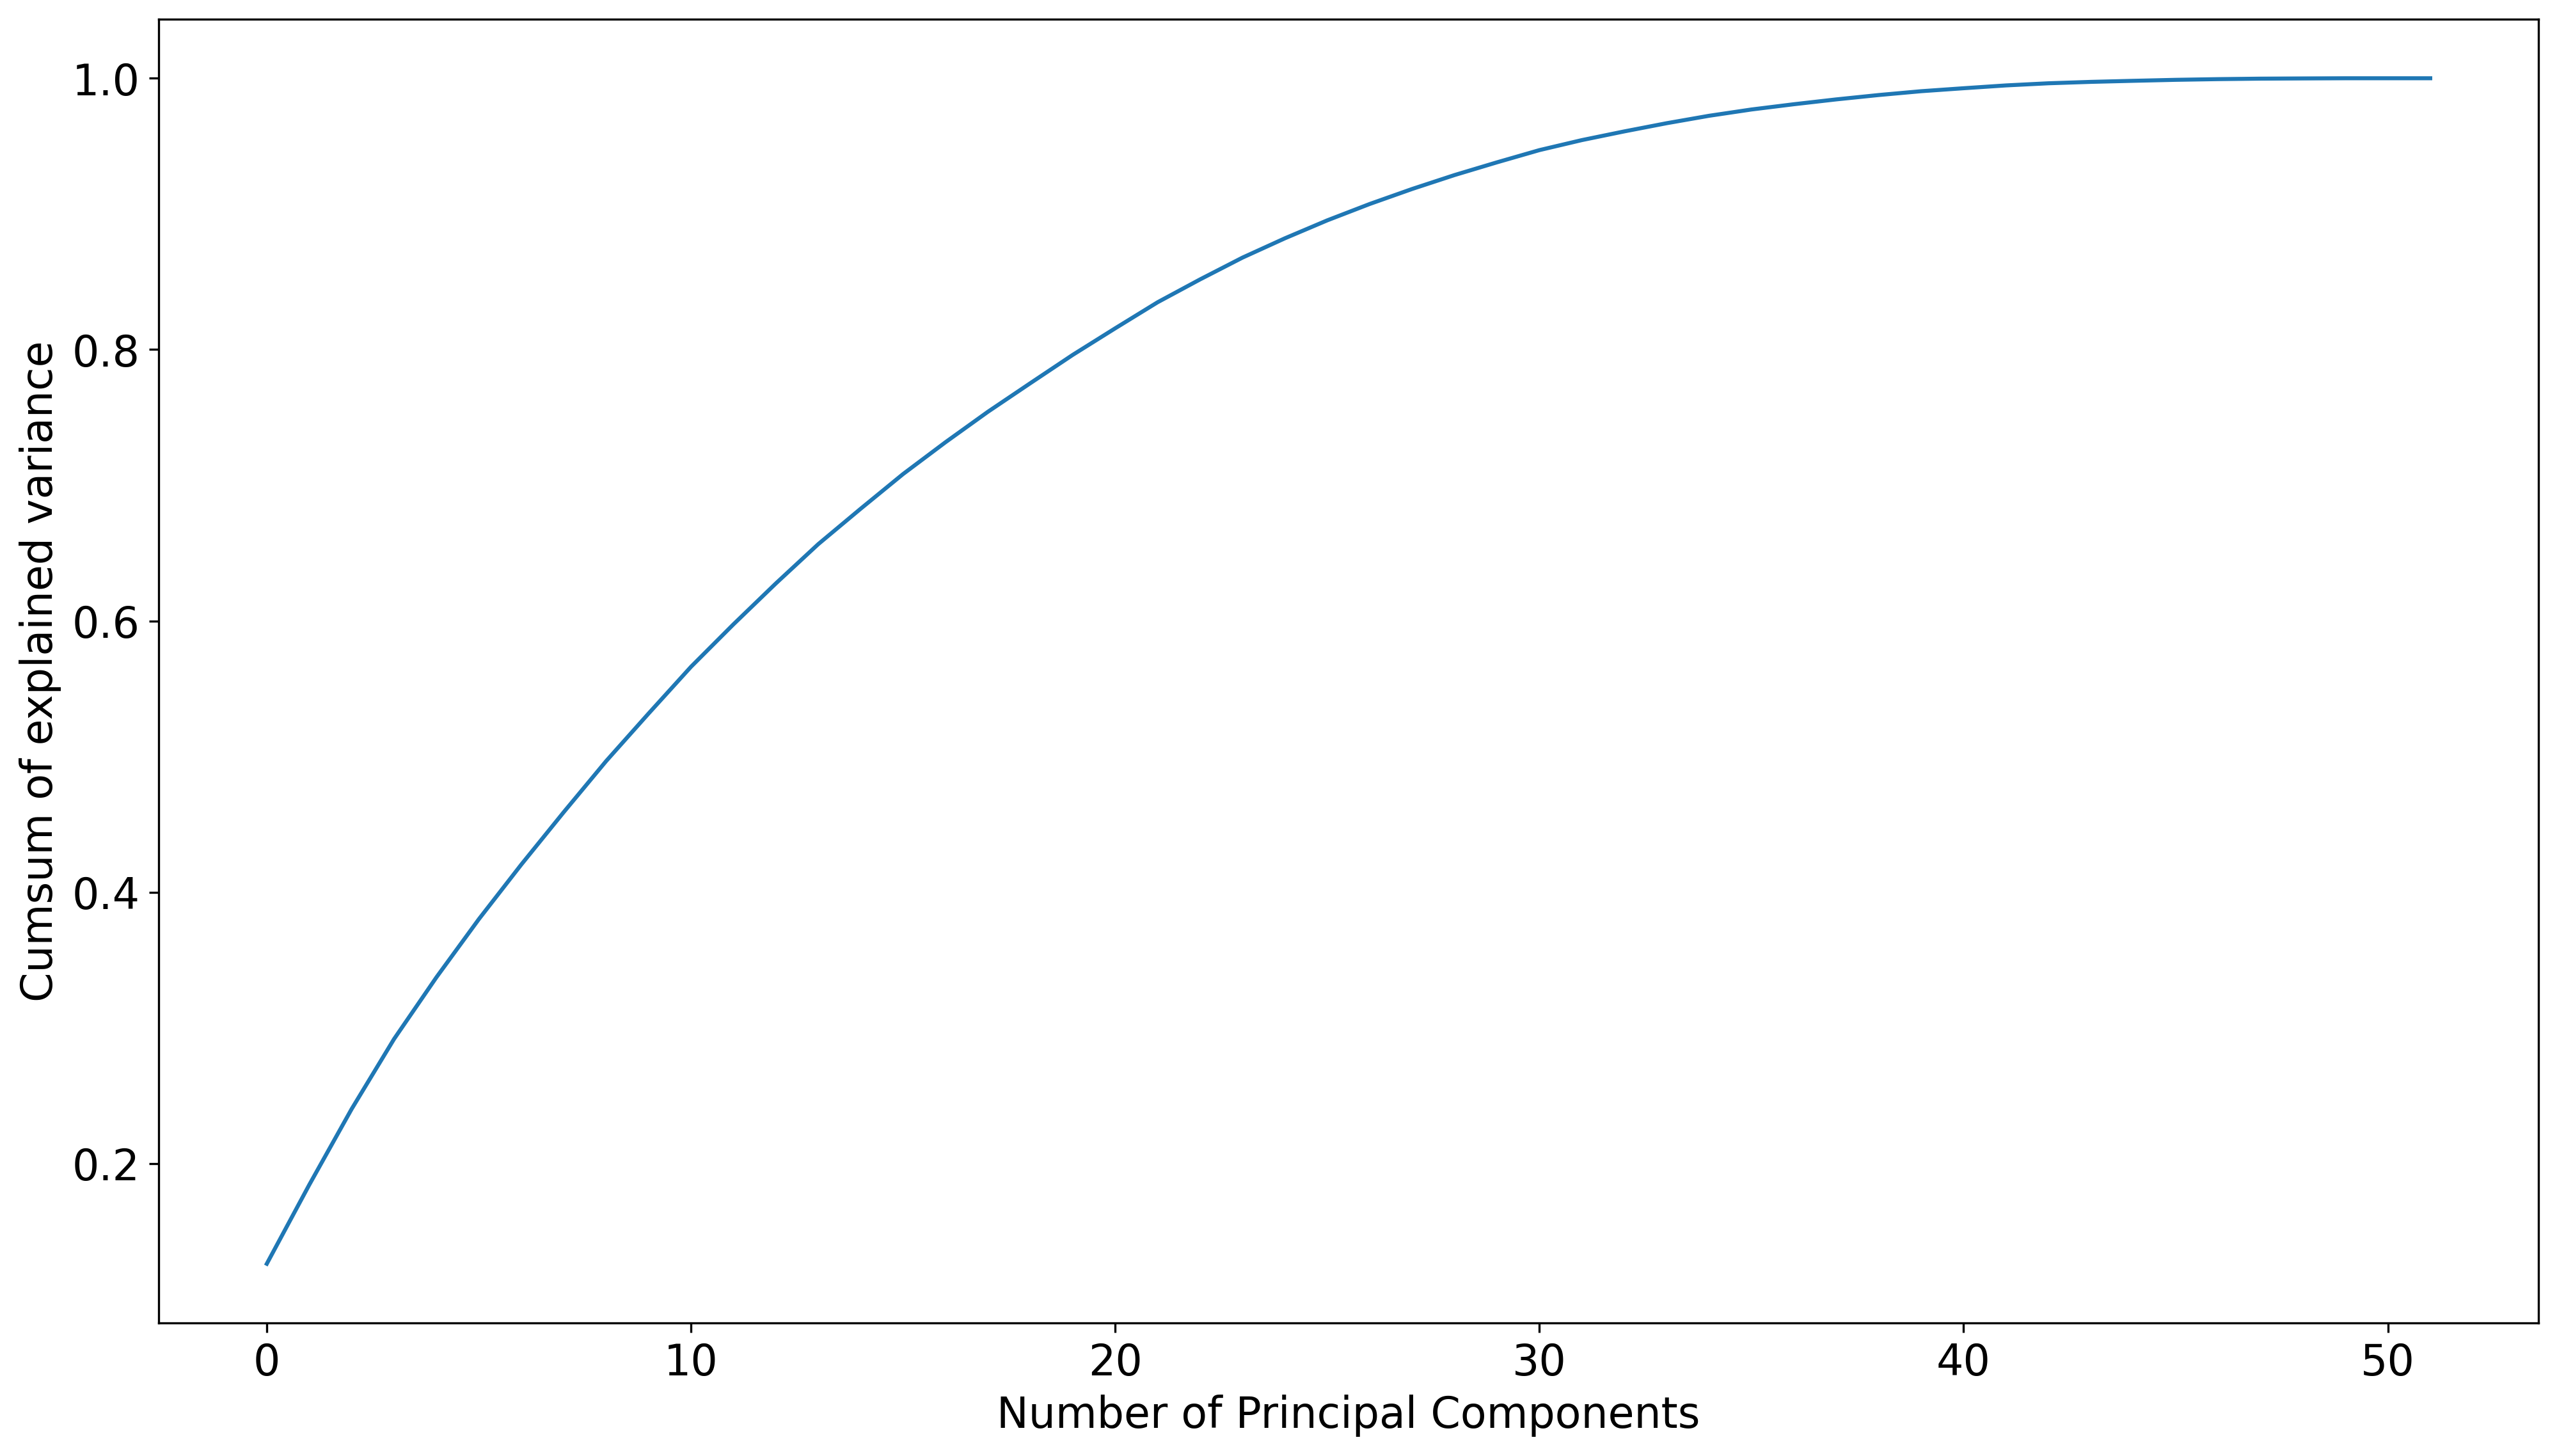

In [51]:
pca = PCA()
pca.fit(defaultrates_states)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumsum of explained variance')
plt.show

In [ ]:
# Graficamos 2 compnentes principales

Z = pca.transform(defaultrates_states)

plt.xlabel('Time')
plt.ylabel('Principal_component')
plt.plot(defaultrates_states1.index, Z[:0], alpha=1, label="First PC")
plt.plot(defaultrates_states1.index, Z[:1], alpha=1, color = 'red', linestyle='dashed',label="Second PC")
plt.legend(loc='best')
plt.show

In [ ]:
Z

In [ ]:
# Modelo incluyendo PCA y filtrando variables no significaticas.

In [1]:
## 4. Resultados finales

In [ ]:
## 5. Conclusiones finales

## 6. Bibliografía


1. *Rosch Daniel*, Scheule Harald. Deep Credit Risk. 2020. Amazon Fulfillment, Polonia.

1. *Siddiqi, Naeem*. Credit Risk Scorecards, Developing and Implementing Credit Scoring. 2006. Wiley, New Jersey 


#### Referencias de internet

* [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es-419).

* [LOG LOSS](https://eprints.ucm.es/48800/1/Memoria%20TFM%20Machine%20Learning_Juan_Zamorano_para_difundir%20%282%29.pdf).